In [1]:
# import tropycal.tracks as tracks
from useful_functions import create_genesis_grid_labels
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import skimage.measure as ms
import scipy.ndimage as nd
from itertools import product
import copy
from useful_functions import temporal_spatial_smoothing

In [2]:
# # Time ranges for EVERYTHING desired
month_range = np.arange(1,13,1).astype(float)
test_years = np.arange(2005,2021,1).astype(float)
train_years = np.arange(1950,2005,1).astype(float)
train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,80,2).astype(float)
Longitude=np.arange(260,360,2).astype(float)

# Uncomment below section if you want to recreate genesis (observed) labels, otherwise it is already saved

In [3]:
# #Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_dataset(name='Genesis_Grids').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_dataset(name='Genesis_Grids').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")

In [4]:
testlabelpoints_open = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_label_points_obs.nc")
trainlabelpoints_open = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_label_points_obs.nc")
testprobs_formatted_open = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/probabilities_prediction.nc").rename({'__xarray_dataarray_variable__':'ML Model Probs'})


train_labels_zerod = np.where(trainlabelpoints_open['Genesis_Grids'] < 0, 0, trainlabelpoints_open['Genesis_Grids'])
train_labels_zerod_XR = xr.DataArray(train_labels_zerod,coords=[trainlabelpoints_open.coords['Month'],
                                        trainlabelpoints_open.coords['Latitude'],
                                        trainlabelpoints_open.coords['Longitude'],
                                        trainlabelpoints_open.coords['Year']])

test_labels_zerod = np.where(testlabelpoints_open['Genesis_Grids'] < 0, 0, testlabelpoints_open['Genesis_Grids'])
test_labels_zerod_XR = xr.DataArray(test_labels_zerod,coords=[testlabelpoints_open.coords['Month'],
                                        testlabelpoints_open.coords['Latitude'],
                                        testlabelpoints_open.coords['Longitude'],
                                        testlabelpoints_open.coords['Year']])

testprobs_formatted_zerod = np.where(np.isnan(testprobs_formatted_open['ML Model Probs']) == True, 0, testprobs_formatted_open['ML Model Probs'])
testprobs_labels_zerod_XR = xr.DataArray(testprobs_formatted_zerod,coords=[testprobs_formatted_open.coords['Month'],
                                        testprobs_formatted_open.coords['Latitude'],
                                        testprobs_formatted_open.coords['Longitude'],
                                        testprobs_formatted_open.coords['Year']])

train_canes_use = copy.deepcopy(train_labels_zerod_XR).astype(float)
test_canes_use = copy.deepcopy(test_labels_zerod_XR).astype(float)
combined_pre = xr.concat([train_canes_use,test_canes_use],dim='Year')

In [5]:
# Read in Data

# train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# train_labels_predropped = train_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

# test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
# test_labels_predropped = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

# Deep copy the dataset so it is not referencing

# Smoothing the climatology individual years for full dataset (temporal and spatial!)

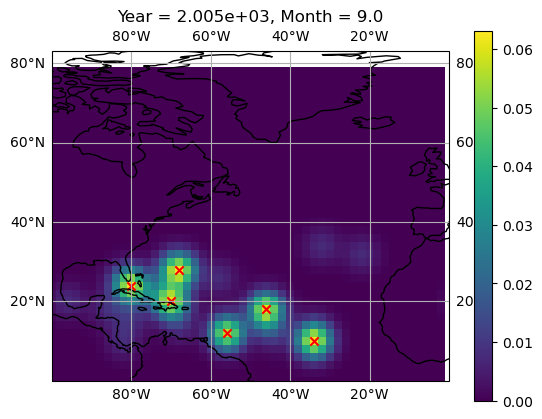

In [5]:
combined = copy.deepcopy(combined_pre)
spatially_temporally_filtered_XR = temporal_spatial_smoothing(combined,0.5,1.5)
# Plot temporally then spatially filtered data
mo_val = 9
yr_val = 2005
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
spatially_temporally_filtered_XR.sel(Month=mo_val,Year=yr_val).plot()
tmp_scat = combined_pre.sel(Month=mo_val,Year=yr_val).stack(new=['Latitude','Longitude'])
tmp_scat = tmp_scat.where(tmp_scat>0,drop=True)
ax.scatter(tmp_scat['Longitude'],tmp_scat['Latitude'],marker='x',color='r')
plt.savefig("Spatial_Temporal_Filtered.png",dpi=300)

# Smooth Random Forest Results

In [27]:
testprobs_labels_zerod_XR_copy = copy.deepcopy(testprobs_labels_zerod_XR)
ML_model_threshed = (testprobs_labels_zerod_XR_copy>0.065)
ML_test_smoothed = temporal_spatial_smoothing(ML_model_threshed.astype(float),0.5,1.5)

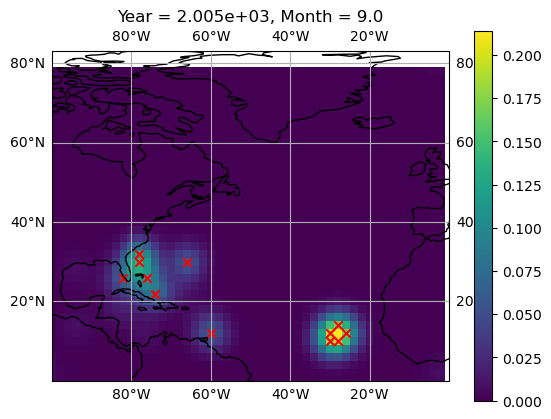

In [28]:
plt.figure()
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.set_global()
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_extent([-100, 0, 0, 80])
model_scat = ML_model_threshed.sel(Month=mo_val,Year=yr_val).stack(new=['Latitude','Longitude'])
model_scat = model_scat.where(model_scat>0,drop=True)
ML_test_smoothed.sel(Month=mo_val,Year=yr_val).plot()
ax1.scatter(model_scat['Longitude'],model_scat['Latitude'],marker='x',color='r')


# Evaluate smoothed results to smoothed random forest results

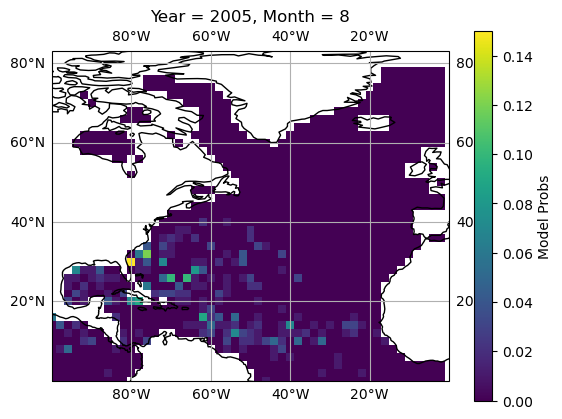

In [28]:
# plt.figure()
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# ax.gridlines(draw_labels=True)
# ax.set_extent([-100, 0, 0, 80])
# testprobs_formatted_open['Model Probs'].sel(Month=8,Year=2005).plot()
# plt.savefig('Model_Output.png',dpi=600)

# Monthly Temporal Smoothing (Climo; Entire Dataset)!

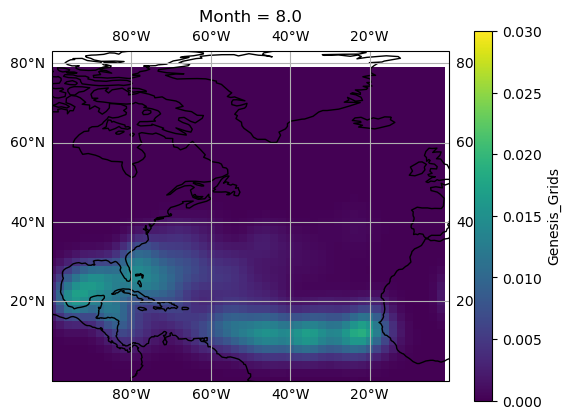

In [6]:
num_years = len(train_labels_predropped_read["Year"]) # Number of Years

# Sum by month, across all years
sum_canes = combined_pre.groupby("Month").sum("Year", skipna=True).astype(float)
# three_sum_canes = xr.concat([sum_canes,sum_canes,sum_canes],dim="Month").astype(float)

Gauss_SmoothAN = sum_canes/num_years
# Temporal Smoothing
for i, j in product(range(len(Gauss_SmoothAN[0,:,0])),range(len(Gauss_SmoothAN[0,0,:]))): # Loop over all grid cells
    Gauss_SmoothAN[:,i,j] = gaussian_filter(Gauss_SmoothAN[:,i,j], sigma=1.5,mode='wrap') # temporal filter

# Spatial Smoothing
for loop in range(Gauss_SmoothAN.shape[0]):
    Gauss_SmoothAN[loop,:,:] = gaussian_filter(Gauss_SmoothAN[loop,:,:].astype(float),sigma=1.5,mode='wrap') # spatial filter

# Plot climo data of specified month
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
Gauss_SmoothAN.sel(Month=8).plot(vmin=0,vmax=0.03)
plt.savefig('climo_double_smoothed.png',dpi=600)

# Make anomaly plots!

In [22]:
# all_train_anomalies = [] # List of anomaly data of all months
# for month_range_now in month_range: # Loop over every month
#     train_anomalies_indiv_month = spatially_temporally_filtered_XR.sel(Month=month_range_now)-Gauss_SmoothAN.sel(Month=month_range_now)
#     all_train_anomalies.append(train_anomalies_indiv_month) # Calculate anomaly of each month

# # Convert from list to XR
# all_train_anomalies_xr = xr.DataArray(all_train_anomalies,coords=[spatially_temporally_filtered_XR.coords["Month"],
#                                          spatially_temporally_filtered_XR.coords["Latitude"],
#                                         spatially_temporally_filtered_XR.coords["Longitude"],
#                                         spatially_temporally_filtered_XR.coords["Year"]])

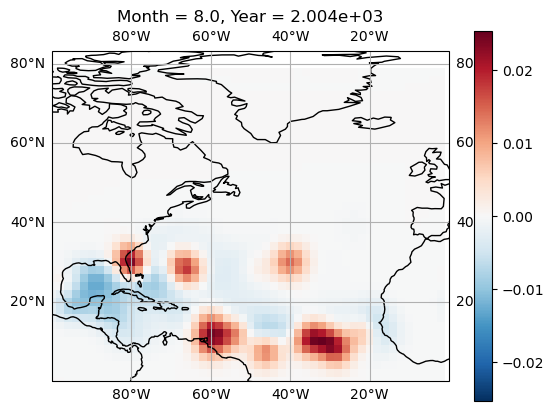

In [23]:
# Make anomaly plot for desired month and year

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
all_train_anomalies_xr.sel(Month=8,Year=2004).plot()
plt.savefig("Anomaly_Plot.png",dpi=600)